In [1]:
import findspark
findspark.init()
findspark.find()

'H:\\SPARK'

In [2]:
from pyspark.sql import SparkSession

# Initialize SparkSession with necessary configurations
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('Spark') \
    .config("spark.driver.memory", "15g") \
    .config("spark.hadoop.home.dir", "H:/HADOOP/") \
    .config("spark.hadoop.conf.dir", "H:/HADOOP/etc/hadoop/") \
    .getOrCreate()
    
import sys
sys.path.append("G:\Dissertation_Project")

# Get SparkContext from the SparkSession
sc = spark.sparkContext


In [3]:
spark

### BASE DATASET

In [4]:
base_df = spark.read.csv("../../Data/Custom_Datasets/conversation_datasets_GPT.csv", header=True, inferSchema=True)
base_df.show(10, truncate=False)

+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|Conversation_ID|Attacker_Helper                                                                                                                                                 |Victim                                                                                                                                                                                         |Conversation_Type|
+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------

### PREPROCESSED DATASET

In [5]:
preprocessed_df = spark.read.csv("../../Data/Preprocessed_Datasets/GPT_dataset_preprocessed.csv", header=True, inferSchema=True)
preprocessed_df.show(10, truncate=False)

+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Convert Conversation Columns into actual Arrays

In [6]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
import ast

# UDF to convert string representation of list to actual list
def str_to_array_of_arrays(s):
    # Convert the string to a list and then wrap it inside another list
    return [ast.literal_eval(s)][0]

str_to_array_of_arrays_udf = udf(str_to_array_of_arrays, ArrayType(ArrayType(StringType())))

df = preprocessed_df.withColumn("Attacker_Helper", str_to_array_of_arrays_udf(preprocessed_df["Attacker_Helper"])).withColumn("Victim", str_to_array_of_arrays_udf(preprocessed_df["Victim"]))

df.printSchema()

root
 |-- Conversation_ID: string (nullable = true)
 |-- Attacker_Helper: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Victim: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Conversation_Type: integer (nullable = true)



### Loading the pipeline and transforming the data

In [7]:
from pyspark.ml import PipelineModel
from src.CustonTransformers import FlattenTransformer

pipeline_model_path = "./Pipelines/TF-IDF_Pipeline"

pipeline = PipelineModel.load(path=pipeline_model_path)

df_assembled = pipeline.transform(df)

### Splitting the Data

In [8]:
(train_data, test_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)
train_data.show(truncate=False)

+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# NEURAL NETWORK

## Creating a LSTM neural network using keras. 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Preparing the data to be used as input in the Neural Network

In [10]:
import numpy 

labels = train_data.select('Conversation_Type').rdd.map(lambda row: row.Conversation_Type).collect()
labels_numpy_train = numpy.array(labels)

print("Shape of -labels_numpy_train- array --> {}".format(labels_numpy_train.shape))

features = train_data.select('combined_features').rdd.map(lambda row: row.combined_features).collect()
features_numpy_train = numpy.array(features)
features_numpy_train = numpy.expand_dims(features_numpy_train, axis=1)

print("Shape of -features_numpy_train- array --> {}".format(features_numpy_train.shape))

###############################################################################################################

labels = test_data.select('Conversation_Type').rdd.map(lambda row: row.Conversation_Type).collect()
labels_numpy_test = numpy.array(labels)

print("Shape of -labels_numpy_train- array --> {}".format(labels_numpy_test.shape))

features = test_data.select('combined_features').rdd.map(lambda row: row.combined_features).collect()
features_numpy_test = numpy.array(features)
features_numpy_test = numpy.expand_dims(features_numpy_test, axis=1)

print("Shape of -features_numpy_train- array --> {}".format(features_numpy_test.shape))



Shape of -labels_numpy_train- array --> (498,)
Shape of -features_numpy_train- array --> (498, 1, 400)
Shape of -labels_numpy_train- array --> (92,)
Shape of -features_numpy_train- array --> (92, 1, 400)


In [11]:
model = Sequential([
    LSTM(32, input_shape=(1, 400), return_sequences=True),
    Dropout(0.5),
    LSTM(16, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [12]:
from keras import backend as K
import tensorflow as tf
# Custom F1Score metric 
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        self.f1_score = 2 * ((p * r) / (p + r + K.epsilon()))
        return self.f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])

In [13]:
# early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(features_numpy_train, labels_numpy_train, epochs=160, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/160
13/13 [==============================] - 4s 77ms/step - loss: 0.6873 - accuracy: 0.5578 - precision: 0.5576 - recall: 0.8598 - f1_score: 0.6765 - val_loss: 0.6790 - val_accuracy: 0.6100 - val_precision: 0.5843 - val_recall: 0.9630 - val_f1_score: 0.7273
Epoch 2/160
13/13 [==============================] - 0s 7ms/step - loss: 0.6708 - accuracy: 0.6181 - precision: 0.5871 - recall: 0.9766 - f1_score: 0.7333 - val_loss: 0.6579 - val_accuracy: 0.5800 - val_precision: 0.5652 - val_recall: 0.9630 - val_f1_score: 0.7123
Epoch 3/160
13/13 [==============================] - 0s 7ms/step - loss: 0.6412 - accuracy: 0.7211 - precision: 0.6700 - recall: 0.9486 - f1_score: 0.7853 - val_loss: 0.6205 - val_accuracy: 0.7700 - val_precision: 0.7313 - val_recall: 0.9074 - val_f1_score: 0.8099
Epoch 4/160
13/13 [==============================] - 0s 7ms/step - loss: 0.5881 - accuracy: 0.8191 - precision: 0.7731 - recall: 0.9393 - f1_score: 0.8481 - val_loss: 0.5551 - val_accuracy: 0.7900 - val_p

### Testing the LSTM network

In [14]:
test_loss, test_accuracy, test_precision, test_recall, test_f1score = model.evaluate(features_numpy_test, labels_numpy_test)
print(f"test_accuracy --> {test_accuracy}")
print(f"test_loss --> {test_loss}")
print(f"test_precision --> {test_precision}")
print(f"test_recall --> {test_recall}")
print(f"test_f1score --> {test_f1score}")

3/3 [==============================] - 0s 6ms/step - loss: 0.1522 - accuracy: 0.9457 - precision: 0.9796 - recall: 0.9231 - f1_score: 0.9505
test_accuracy --> 0.945652186870575
test_loss --> 0.15215449035167694
test_precision --> 0.9795918464660645
test_recall --> 0.9230769276618958
test_f1score --> 0.9504950642585754


### Saving the model

In [15]:
model.save("../Models/Trained_Models/LSTM_NeuralNetwork_TFIDF/LSTM_NeuralNetwork_TFIDF.keras")

### Plotting the training results

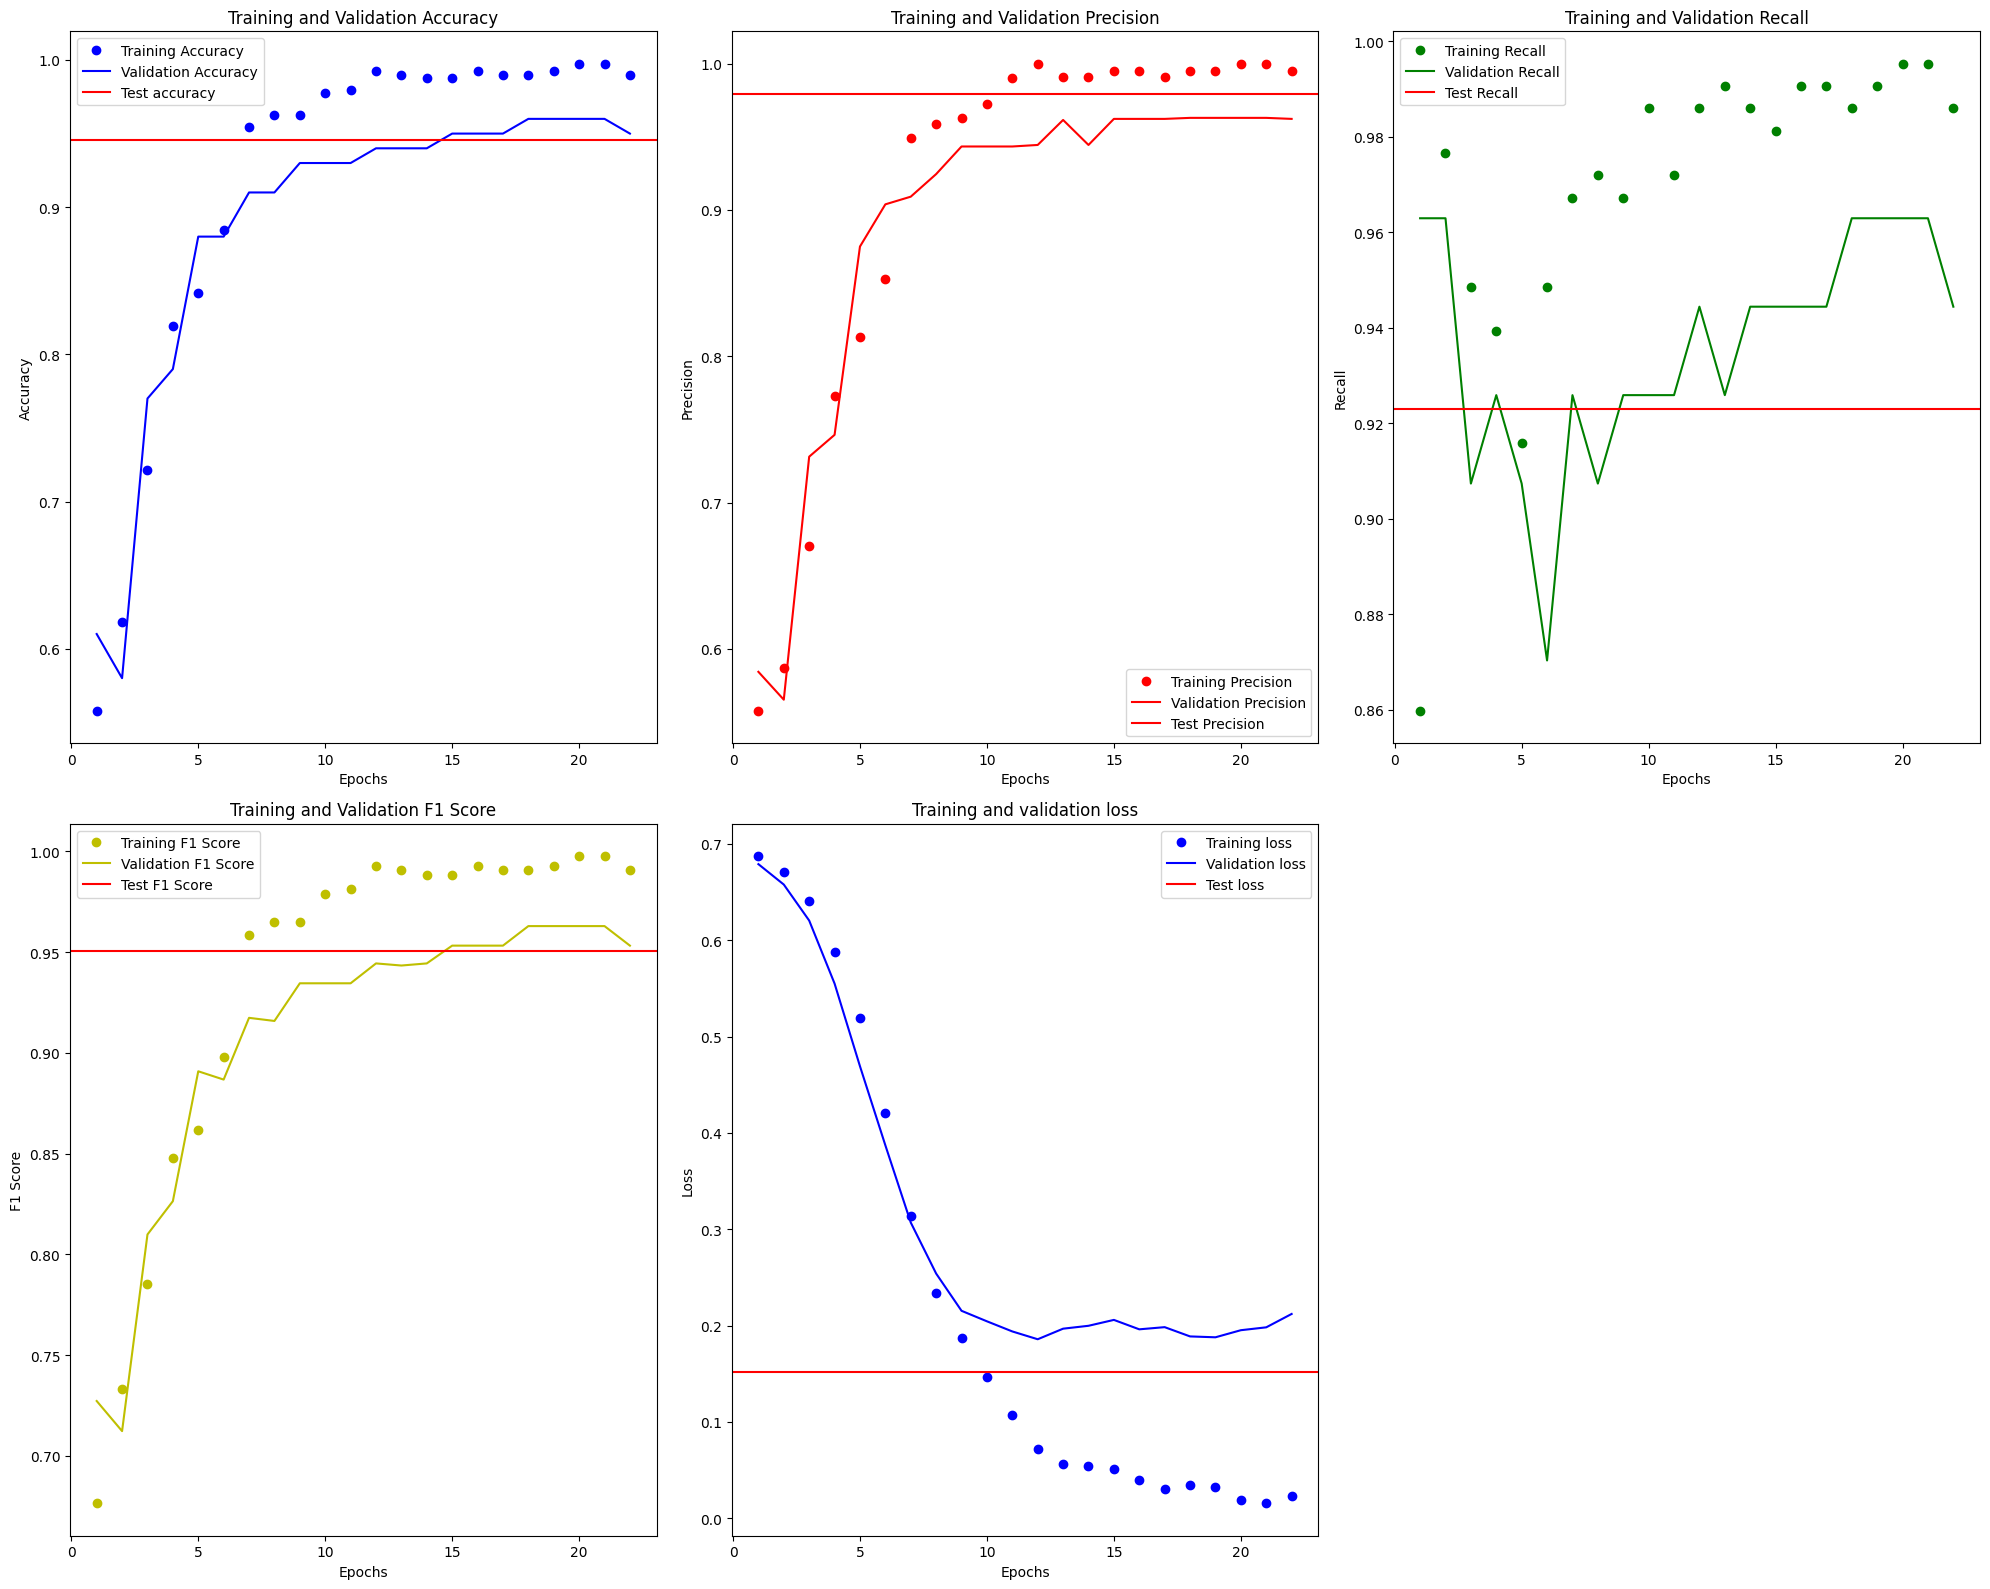

In [18]:
import matplotlib.pyplot as plt

# Extract history for each metric
history_dict = history.history

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, int(len(accuracy) + 1))

plt.figure(figsize=(20, 16))

# Plot training and validation accuracy
plt.subplot(2, 3, 1)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation precision
plt.subplot(2, 3, 2)
plt.plot(epochs, precision, 'ro', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.axhline(y=test_precision, color='r', linestyle='-', label='Test Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot training and validation recall
plt.subplot(2, 3, 3)
plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.axhline(y=test_recall, color='r', linestyle='-', label='Test Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot training and validation F1 Score
plt.subplot(2, 3, 4)
plt.plot(epochs, f1_score, 'yo', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'y', label='Validation F1 Score')
plt.axhline(y=test_f1score, color='r', linestyle='-', label='Test F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(2, 3, 5)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axhline(y=test_loss, color='r', linestyle='-', label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])
